In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


kinematics_all = pd.read_pickle("kinematics_all.pkl")

kinematics_anom = pd.read_pickle("kinematics_anom.pkl")

training_kinematics = pd.read_pickle("training_kinematics.pkl")

2025-12-03 18:14:50.902635: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
X = training_kinematics[['pt1','eta1','phi1','pt2','eta2','phi2','pt3','eta3','phi3','pt4','eta4','phi4','Ntracks']].values
# # Extract mass separately
# mass = df['mass'].values
mass = training_kinematics['InvariantMass'].values
# # Create a train/test split
X_train, X_test, mass_train, mass_test = train_test_split(X, mass, test_size=0.05, random_state=42)

from sklearn.preprocessing import MinMaxScaler

# Initialize scaler
scaler = MinMaxScaler()

# Fit and transform training data, transform test data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape, X_test.shape)

(285000, 13) (15000, 13)


In [3]:
print(X_train.shape[0])

285000


In [4]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Available devices:", tf.config.list_physical_devices())
# tf.debugging.set_log_device_placement(True)

TensorFlow version: 2.16.2
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU (if any)

In [6]:
# #------------------------------------------
# # 2. Define the Autoencoder Model
# #------------------------------------------

input_dim = X_train.shape[1]  # should be 6
encoding_dim = 8             # latent space dimension

# # Input layer
input_layer = Input(shape=(input_dim,))

# # Encoding layer (compression)
encoded = Dense(encoding_dim, activation='relu')(input_layer)

# # Decoding layer (reconstruction)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# # Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)
# autoencoder.compile(optimizer='adam', loss='mse')
from tensorflow.keras.optimizers import Adam
autoencoder.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
# autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse') # best, 185 epochs automatic stop

#------------------------------------------
# 3. Train the Autoencoder
#------------------------------------------

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=2,
    restore_best_weights=True
)

history = autoencoder.fit(X_train, X_train, 
                          epochs=500,
                          # epochs=500,
                          batch_size=256,
                        #   batch_size=64,
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          verbose=2,
                          callbacks=[early_stopping]
                         )

# with tf.device('/CPU:0'):
#     history = autoencoder.fit(X_train, X_train,
#                               epochs=500,
#                               batch_size=64,
#                               validation_data=(X_test, X_test),
#                               callbacks=[early_stopping],
#                               verbose=2)
#     print(f"Training stopped at epoch {len(history.history['loss'])}")

print(f"Training stopped at epoch {len(history.history['loss'])}")


Epoch 1/500
1114/1114 - 6s - 5ms/step - loss: 0.0067 - val_loss: 8.6313e-04
Epoch 2/500
1114/1114 - 2s - 2ms/step - loss: 6.4704e-04 - val_loss: 5.2172e-04
Epoch 3/500
1114/1114 - 2s - 2ms/step - loss: 4.7601e-04 - val_loss: 4.7150e-04
Epoch 4/500
1114/1114 - 2s - 2ms/step - loss: 4.5921e-04 - val_loss: 4.6796e-04
Epoch 5/500
1114/1114 - 2s - 2ms/step - loss: 4.5294e-04 - val_loss: 4.6080e-04
Epoch 6/500
1114/1114 - 2s - 2ms/step - loss: 4.4864e-04 - val_loss: 4.5473e-04
Epoch 7/500
1114/1114 - 2s - 2ms/step - loss: 4.4522e-04 - val_loss: 4.5056e-04
Epoch 8/500
1114/1114 - 2s - 2ms/step - loss: 4.4168e-04 - val_loss: 4.5126e-04
Epoch 9/500
1114/1114 - 3s - 3ms/step - loss: 4.3833e-04 - val_loss: 4.4383e-04
Epoch 10/500
1114/1114 - 2s - 2ms/step - loss: 4.3439e-04 - val_loss: 4.4777e-04
Epoch 11/500
1114/1114 - 3s - 2ms/step - loss: 4.3097e-04 - val_loss: 4.5600e-04
Training stopped at epoch 11


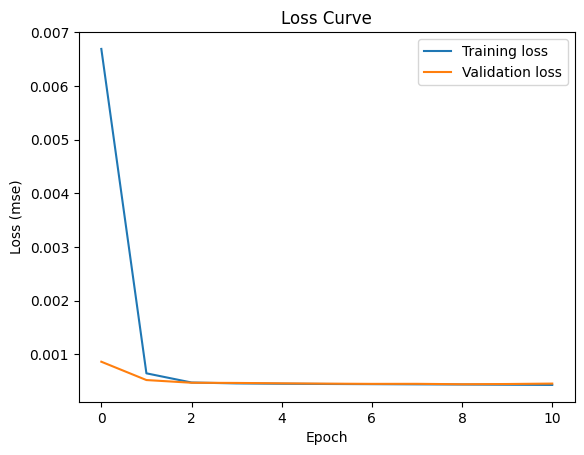

In [7]:
# Optional: Plot the loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (mse)')
plt.title('Loss Curve')
plt.legend()
#plt.savefig("final_loss2.pdf")
plt.show()

In [8]:
# #------------------------------------------
# # 4. Use the Autoencoder for Anomaly Detection
# #------------------------------------------

# # Compute reconstruction on the test set
X_test_pred = autoencoder.predict(X_test)

# # Calculate MSE per sample
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)
#plot

# You need to define a threshold for what you consider "anomalous"
# This could be determined by analyzing the MSE distribution on training data, for example.
threshold = 1 #np.mean(mse) + 3*np.std(mse)  # Example heuristic

# Find anomalous events
anomalous_indices = np.where(mse > threshold)[0]

#------------------------------------------
# 5. Retrieve the Mass for Anomalous Events
#------------------------------------------

# For any anomalous event, we can now look up its mass
if len(anomalous_indices) > 0:
    print("Anomalous Event Indices:", anomalous_indices)
    print("Mass values for anomalous events:", mass_test[anomalous_indices])
else:
    print("No anomalies detected under this threshold.")


469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
No anomalies detected under this threshold.


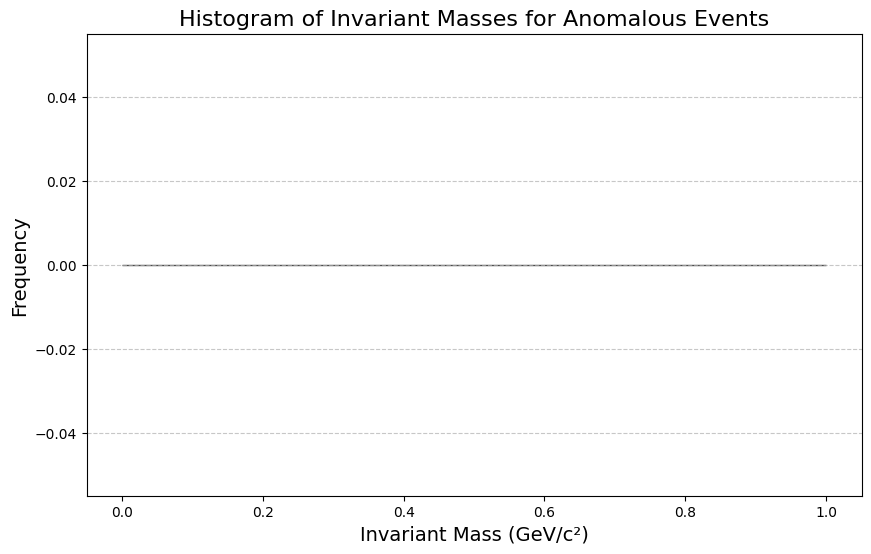

In [9]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(mass_test[anomalous_indices], bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of Invariant Masses for Anomalous Events', fontsize=16)
plt.xlabel('Invariant Mass (GeV/c²)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for better readability
plt.show()

In [10]:
#PROTONS ONLY 

kinematics_all = kinematics_all[kinematics_all['InvariantMass'] > 0]
kinematics_all

kinematics_anom = kinematics_anom[kinematics_anom['InvariantMass'] > 0]
kinematics_anom

#No exotica

X_alice_noexotica = kinematics_all[['pt1','eta1','phi1','pt2','eta2','phi2','pt3','eta3','phi3','pt4','eta4','phi4','Ntracks']].values
X_alice_noexotica = scaler.transform(X_alice_noexotica)

X_alice_noexotica_pred = autoencoder.predict(X_alice_noexotica)

mse_alice_noexotica = np.mean(np.power(X_alice_noexotica - X_alice_noexotica_pred, 2), axis=1)


# ALICE, with exotica

X_alice_exotica=kinematics_anom[['pt1','eta1','phi1','pt2','eta2','phi2','pt3','eta3','phi3','pt4','eta4','phi4','Ntracks']].values
X_alice_exotica = scaler.transform(X_alice_exotica)

X_alice_exotica_pred = autoencoder.predict(X_alice_exotica)

mse_alice_exotica = np.mean(np.power(X_alice_exotica - X_alice_exotica_pred, 2), axis=1)


165383/165383 ━━━━━━━━━━━━━━━━━━━━ 381s 2ms/step
165679/165679 ━━━━━━━━━━━━━━━━━━━━ 376s 2ms/step


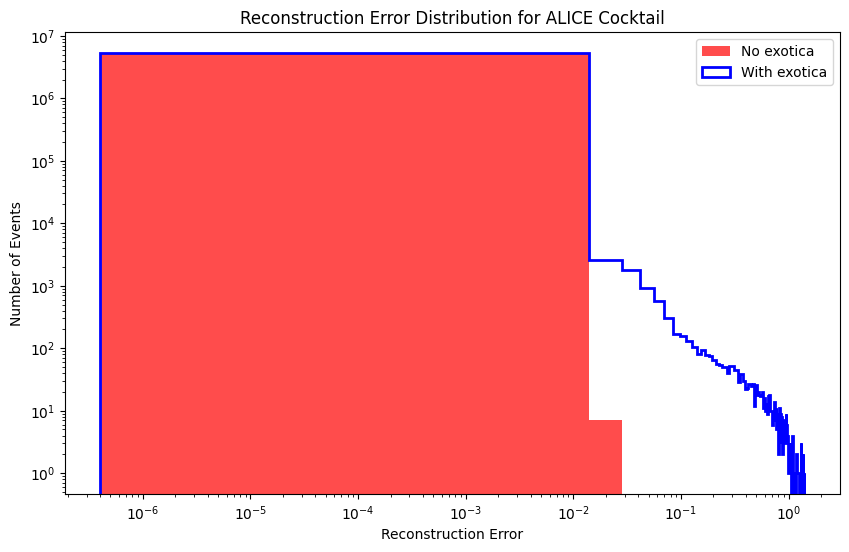

In [ ]:
plt.figure(figsize=(10, 6))
plt.xscale('log')
plt.yscale('log')

combined = np.concatenate([mse_alice_noexotica, mse_alice_exotica])

n_bins = 100

bin_edges = np.linspace(combined.min(), combined.max(), n_bins + 1)

# Plot the filled histogram first
plt.hist(mse_alice_noexotica, bins=bin_edges, color='red', alpha=0.7, label='No exotica')

# Then overlay the contour-only histogram
plt.hist(mse_alice_exotica, bins=bin_edges, histtype='step', color='blue', linewidth=2, label='With exotica')

plt.xlabel('Reconstruction Error')
plt.ylabel('Number of Events')
plt.title('Reconstruction Error Distribution for ALICE Cocktail')
plt.legend()
#plt.savefig('mse-distribution.pdf')
plt.show()


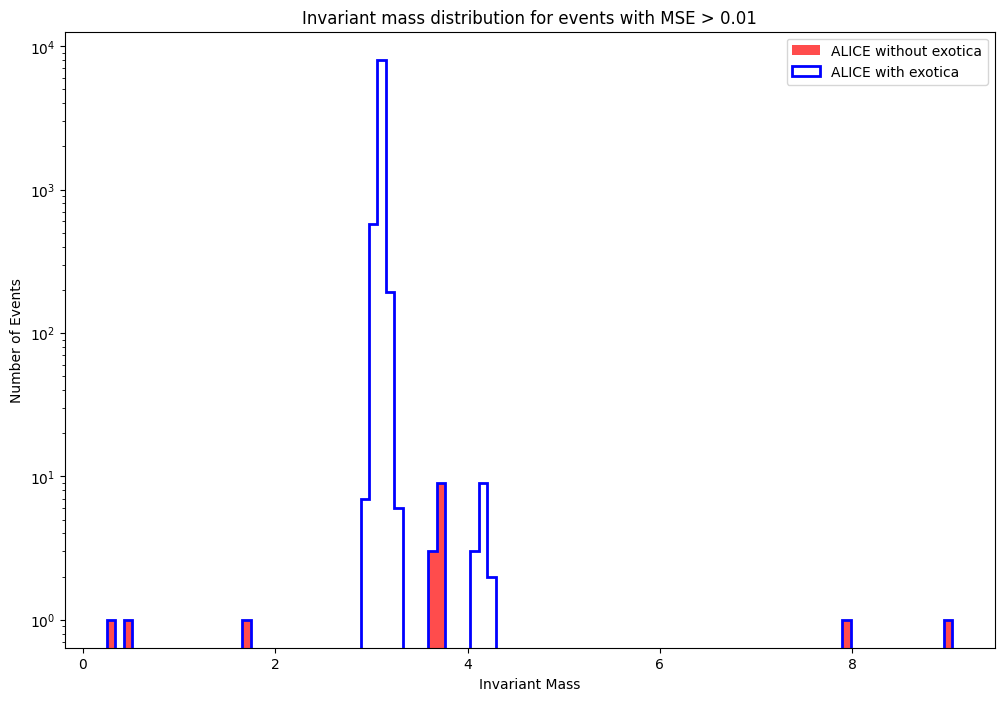

In [15]:
mse_threshold = 0.01
# Filter cocktail no exotica with reconstruction error above the threshold
alice_noexotica_high_mse = kinematics_all[mse_alice_noexotica > mse_threshold] 
alice_noexotica_masses = alice_noexotica_high_mse['InvariantMass'].values

# Filter cocktail with exotica with reconstruction error above the threshold
alice_exotica_high_mse = kinematics_anom[mse_alice_exotica > mse_threshold]
alice_exotica_masses = alice_exotica_high_mse['InvariantMass'].values


combined_masses = np.concatenate([alice_noexotica_masses, alice_exotica_masses])

n_bins = 100

bin_edges = np.linspace(combined_masses.min(), combined_masses.max(), n_bins + 1)

# Plot the invariant mass distribution
plt.figure(figsize=(12, 8))

# plt.hist(alice_noexotica_masses, bins=100, alpha=0.7, label='ALICE without exotica', color='blue')
# plt.hist(alice_exotica_masses, bins=100, alpha=0.7, label='ALICE with exotica', color='red')

plt.hist(alice_noexotica_masses, bins=bin_edges, color='red', alpha=0.7, label='ALICE without exotica')
plt.hist(alice_exotica_masses, bins=bin_edges, histtype='step', color='blue', linewidth=2, label='ALICE with exotica')

# ax = plt.gca()
# # ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.99), ncol=2)
# ax.set_xlim([2.7, 4.])
# ax.set_ylim([0.1, 100])

# Add labels and title
plt.xlabel('Invariant Mass')
plt.ylabel('Number of Events')
#plt.xlim(2.8,3.4)
# plt.ylim(0,10)
plt.yscale('log')
plt.title(f'Invariant mass distribution for events with MSE > {mse_threshold}')
plt.legend()
#plt.savefig('mse-inv-mass.pdf')

# Show the plot
plt.show()


In [14]:
anom_jpsi_count = np.sum((alice_exotica_masses >= 2.85) & (alice_exotica_masses <= 3.2))
print(anom_jpsi_count)

norm_jpsi_count = np.sum((alice_noexotica_masses >= 2.85) & (alice_noexotica_masses <= 3.2))
print(norm_jpsi_count)

anom_pq_count = np.sum((alice_exotica_masses >= 4) & (alice_exotica_masses <= 5))
print(anom_pq_count)

norm_pq_count = np.sum((alice_noexotica_masses >= 4) & (alice_noexotica_masses <= 5))
print(norm_pq_count)

8810
0
14
0
